# Summary
In notebook `4.0` we created a dataloader that will return 12 leads. In notebook `5.0` we created a notebook that loads, resamples and saves the `MIT stress noise signals`.  
In this notebook we combine everything, to create a dataloader that loads 12 leads, and corrupts some of them, in order to train an $R^{12}->R^{12}$ auto encoder for imputation.  

I choose to create a data curroptors to be defined *outside* of the data loader, so, when in training, I can change it over time, without effecting the dataloader. I want to feed the model with easier data at the beggining of the training. 

In [1]:
import os
# set path to proj
os.chdir('/Users/davidharar/Documents/School/thesis/upstream_seq2seq/')

In [2]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from typing import List
from sklearn.preprocessing import MinMaxScaler

class DataGenerator_12leads():
    def __init__(self,
                 data_folder_path:str, # path to relevant folder
                 batch_size:int,       # batch size
                 list_IDs:List[str],   # list of relevat IDs (each ID is given in a <file>_<person> format)
                 shuffle:bool = True   # Whether to shuffle the list of IDs at the end of each epoch.
                 ):
        
        self.data_path = data_folder_path
        self.leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']
        self.scaler = MinMaxScaler()
        self.list_IDs = list_IDs
        self.indices = np.arange(len(self.list_IDs))
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def _get_sample(self, lead, person, data_folder_path):
        """
        load the relevant <lead> reading .npy file from <data_folder_path>. 
        Inputs:
        - lead:str. The lead we want to load.
        - person:str. The index of the person.
        - data_folder_path:str. The path to the folder when the desired file can be loaded from
        """

        file_name = f'{person.split("_")[0]}_{lead}_{person.split("_")[1]}.npy'
        signal = np.load(data_folder_path+file_name,allow_pickle=True)
        
        # fillna in signal by mean, and take the int of it
        signal[signal!=signal] = int(np.nanmean(signal))

        return signal
    
    def normalize_12_leads(self, leads_signals,scaler):
        return [scaler.fit_transform(leads_signals[j].reshape((-1,1))) if j==0 else scaler.transform(leads_signals[j].reshape((-1,1))) for j in range(12)]


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        import random
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    
    def __data_generation(self, list_IDs_temp):
        """
        Get a list of persons IDs and return a batch of X1 and X2 signals.
        """
        data_path = self.data_path

        # Initialization
        X1 = np.array([[self._get_sample(lead, person_id, data_path) for lead in self.leads] for person_id in list_IDs_temp])
        print('batch_size:', X1.shape)
        return X1
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    
    def __getitem__(self, index):
        'Generate one batch of data using __data_generation'
        # Generate indexes of the batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indices]

        # Generate data
        X1 = self.__data_generation(list_IDs_temp)
        
        # cast to int
        X1=X1.astype(int)

        # # normalize
        X1 = X2 = np.array([self.normalize_12_leads(X1[j],self.scaler) for j in range(X1.shape[0])]).squeeze(-1)

        # X1 = self.scaler.fit_transform(X1.T).T
        # X2 = self.scaler.fit_transform(X2.T).T

        return X1, X2



In [3]:
# --------------------------------
# Usage example
# --------------------------------
import pickle
DESTINATION_FOLDER = './data/processed/'
BATCH_SIZE = 4
with open(DESTINATION_FOLDER+"splits.pkl", 'rb') as handle:
    splits = pickle.load(handle)

train_generator = DataGenerator_12leads(
                                data_folder_path=DESTINATION_FOLDER, # path to relevant folder
                                batch_size=BATCH_SIZE,                        # batch size
                                list_IDs=splits['train'],            # list of relevat IDs (each ID is given in a <file>_<person> format)
                                shuffle = True                       # Whether to shuffle the list of IDs at the end of each epoch.
                                )

X1,X2 = train_generator.__getitem__(0)
print(X1.shape, X2.shape)
X1, X2

batch_size: (4, 12, 5000)
(4, 12, 5000) (4, 12, 5000)


(array([[[ 0.26057906,  0.28285078,  0.22717149, ...,  0.30512249,
           0.30512249,  0.28285078],
         [ 0.27171492,  0.27171492,  0.18485523, ...,  0.27171492,
           0.29398664,  0.27171492],
         [ 0.27171492,  0.24944321,  0.21603563, ...,  0.22717149,
           0.24944321,  0.24944321],
         ...,
         [ 0.16258352,  0.16258352,  0.17371938, ...,  0.27171492,
           0.27171492,  0.28285078],
         [ 0.19599109,  0.20712695,  0.21603563, ...,  0.29398664,
           0.30512249,  0.30512249],
         [ 0.4454343 ,  0.4454343 ,  0.4454343 , ...,  0.28285078,
           0.29398664,  0.29398664]],
 
        [[ 0.24781086,  0.24781086,  0.24781086, ...,  0.34676007,
           0.35113835,  0.35113835],
         [ 0.23992995,  0.23992995,  0.23992995, ...,  0.42732049,
           0.42732049,  0.43607706],
         [ 0.29071804,  0.29071804,  0.29071804, ...,  0.38091068,
           0.3765324 ,  0.38528897],
         ...,
         [ 0.22241681,  0.2224168

In [4]:
def draw_two_or_three_numbers_that_sum_to_one(number_of_numbers):
    """Draws two or three numbers that sum to 1."""
    if number_of_numbers == 2:
        first_number = random.uniform(0, 1)
        second_number = 1 - first_number
        return first_number, second_number
    elif number_of_numbers == 3:
        first_number = random.uniform(0, 1)
        second_number = random.uniform(0, 1 - first_number)
        third_number = 1 - first_number - second_number
        return first_number, second_number, third_number
    else:
        raise ValueError("Please enter 2 or 3.")

draw_two_or_three_numbers_that_sum_to_one(3)

NameError: name 'random' is not defined

In [ ]:
import random

class DataCorruptor():
    def __init__(self,
                 processed_data_folder
                 ):
        
        # load noisy signals
        files = [x for x in os.listdir(processed_data_folder) if x.startswith('noise')]

        MA_noise = [x for x in files if '_MA_' in x]
        BW_noise = [x for x in files if '_BW_' in x]
        EM_noise = [x for x in files if '_EM_' in x]
        
        # store results
        noise_signals = {}
        for noise_type in [MA_noise, BW_noise, EM_noise]:
            noise_str = noise_type[0].split('_')[1]
            noise_long_file = []
            for noise_file in noise_type:
                noise_long_file += np.load(processed_data_folder+noise_file,allow_pickle=True).tolist()
            noise_signals[noise_str]=noise_long_file
        
        self.noise_signals=noise_signals
        self.noise_signal_len = len(noise_signals[noise_str])

        # define probabilities for scrutiny types.
        self.scrutiny_probs = \
            [None]*31+\
            ['Turn-off']*20+\
            ['MA']*7+\
            ['BW']*7+\
            ['EM']*7+\
            ['MA+BW']*7+\
            ['MA+EM']*7+\
            ['BW+EM']*7+\
            ['MA+BW+EM']*7

    def corrupt_with_prob(self,signal):
        noise_type = random.choice(self.scrutiny_probs)
        if noise_type=='Turn-off':
            signal = np.zeros_like(signal)
        elif noise_type is not None:
            SNR = random.uniform(5,25)
            signal = self.forward(signal,noise_type, SNR)
        return signal

    def corrupt_a_batch(self, batch):
        """
        Assuming batch is of shape [batch, leads, len]
        """
        
        def corrupt_an_observation(observation):
            """
            Assuminng observation is given by [leads,len]
            """
            return [self.corrupt_with_prob(observation[j]) for j in range(observation.shape[0])]

        return np.array([corrupt_an_observation(batch[j]) for j in range(batch.shape[0])])


    def create_linear_combination(self, signal, noise, SNR):
        """Creates a linear combination of a signal and noise, given a signal to noise ratio.

        Args:
            signal: A numpy array representing the signal.
            noise: A numpy array representing the noise.
            SNR: The signal to noise ratio.

        Returns:
            A numpy array representing the linear combination of the signal and noise.
        """
        signal = np.array(signal)
        noise = np.array(noise)

        signal_power = np.mean(signal**2)
        noise_power = np.mean(noise**2)
        noise_scaled = noise * np.sqrt(SNR / (signal_power / noise_power))
        return signal + noise_scaled

    def draw_two_or_three_numbers_that_sum_to_one(number_of_numbers):
        """Draws two or three numbers that sum to 1."""
        if number_of_numbers == 2:
            first_number = random.uniform(0, 1)
            second_number = 1 - first_number
            return first_number, second_number
        elif number_of_numbers == 3:
            first_number = random.uniform(0, 1)
            second_number = random.uniform(0, 1 - first_number)
            third_number = 1 - first_number - second_number
            return first_number, second_number, third_number
        else:
            raise ValueError("Please enter 2 or 3.")



    def forward(self, signal, noise_type,SNR):
        # the choice is done outside, in the trainer.
        assert noise_type in ['MA','BW','EM','MA+BW','MA+EM','BW+EM', 'MA+BW+EM'], "Noise type must by one of ['MA','BW','EM','MA+BW','MA+EM','BW+EM', 'MA+BW+EM']."
        
        signal_length = len(signal)

        # create a noisy signal
        # If a signal noise was selected
        if noise_type in ['MA', 'BW', 'EM']:
            
            # draw a random index to start from
            noise_idx = np.random.randint(0,self.noise_signal_len-signal_length) 
            
            # get noise values
            noise = self.noise_signals[noise_type][noise_idx:(noise_idx+signal_length)]
        
        else:
            # break noise_type into seperated noises
            noise_types_ = noise_type.split('+')
            num_types = len(noise_types_)
            weights = draw_two_or_three_numbers_that_sum_to_one(num_types)
            indices = [np.random.randint(0,self.noise_signal_len-signal_length) for j in range(num_types)]

            # get noise values
            noises = []
            for noise_type, weight, indx in zip(noise_types_,weights, indices):
                # get noise values
                unscaled_noise=self.noise_signals[noise_type][indx:(indx+signal_length)]
                # print(type(unscaled_noise))
                unscaled_noise=np.array(unscaled_noise)
                # print(type(unscaled_noise))
                noise = np.array(unscaled_noise)*weight
                noises.append(noise)
                
            # create a combined noise array
            noise = sum(noises)

        # get corrupted signal
        corrupted_signal = self.create_linear_combination(signal, noise, SNR)

        return corrupted_signal


## Test

In [ ]:
data_corruptor = DataCorruptor('./data/processed/')


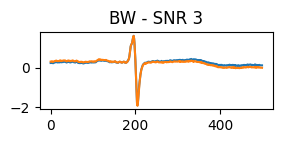

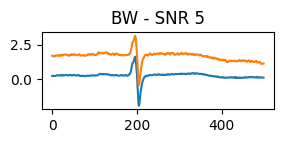

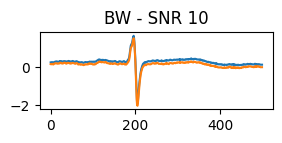

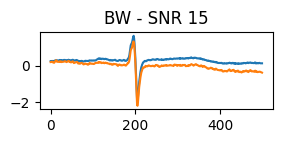

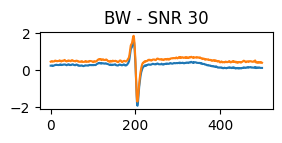

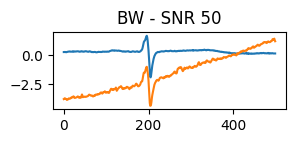

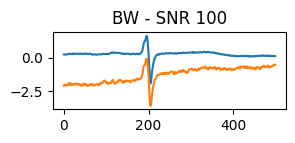

In [ ]:
import matplotlib.pyplot as plt
signal = X1[0][8][:500]

for j in [3,5,10,15,30,50,100]:
    corrupted_signal = data_corruptor.forward(signal, noise_type='BW',SNR=j)
    plt.figure(figsize=(3,1))
    plt.plot(signal)
    plt.plot(corrupted_signal)
    plt.title(f'BW - SNR {j}')
    plt.show()

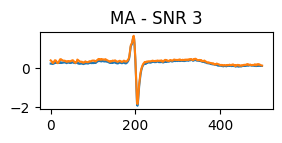

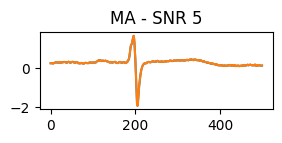

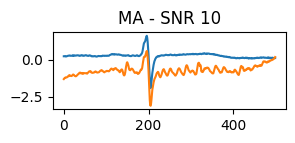

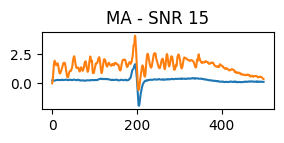

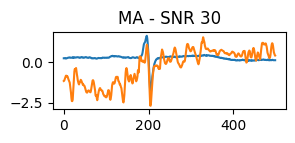

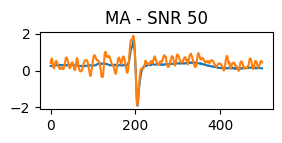

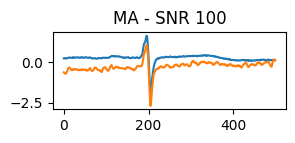

In [ ]:
import matplotlib.pyplot as plt
signal = X1[0][8][:500]

for j in [3,5,10,15,30,50,100]:
    corrupted_signal = data_corruptor.forward(signal, noise_type='MA',SNR=j)
    plt.figure(figsize=(3,1))
    plt.plot(signal)
    plt.plot(corrupted_signal)
    plt.title(f'MA - SNR {j}')
    plt.show()

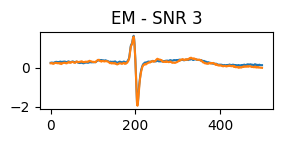

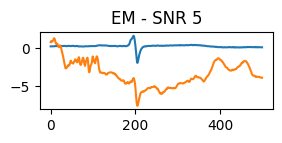

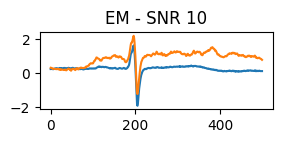

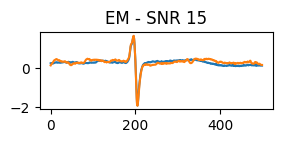

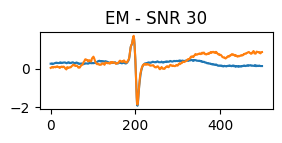

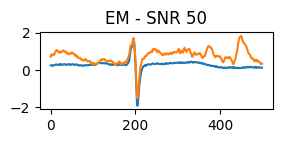

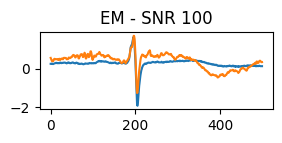

In [ ]:
import matplotlib.pyplot as plt
signal = X1[0][8][:500]

for j in [3,5,10,15,30,50,100]:
    corrupted_signal = data_corruptor.forward(signal, noise_type='EM',SNR=j)
    plt.figure(figsize=(3,1))
    plt.plot(signal)
    plt.plot(corrupted_signal)
    plt.title(f'EM - SNR {j}')
    plt.show()

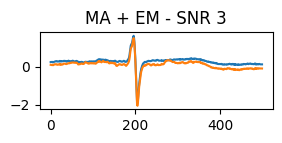

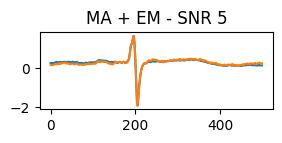

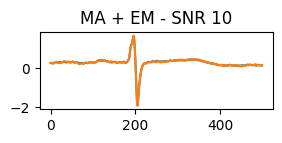

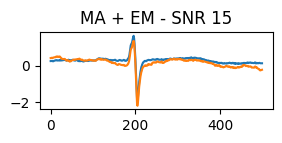

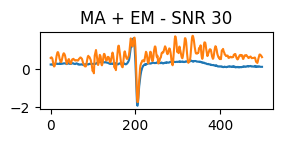

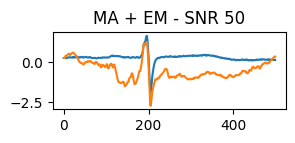

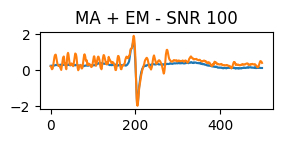

In [ ]:
import matplotlib.pyplot as plt
signal = X1[0][8][:500]

for j in [3,5,10,15,30,50,100]:
    corrupted_signal = data_corruptor.forward(signal, noise_type='MA+EM',SNR=j)
    plt.figure(figsize=(3,1))
    plt.plot(signal)
    plt.plot(corrupted_signal)
    plt.title(f'MA + EM - SNR {j}')
    plt.show()

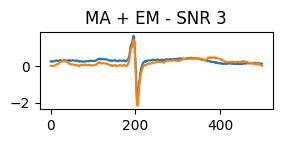

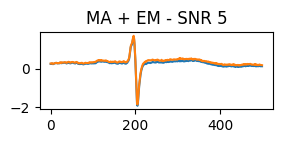

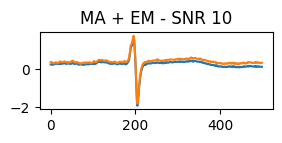

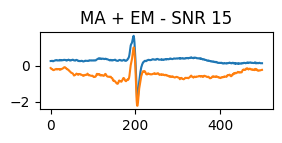

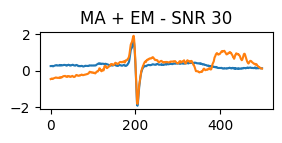

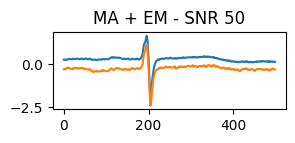

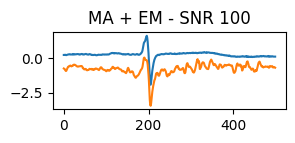

In [ ]:
import matplotlib.pyplot as plt
signal = X1[0][8][:500]

for j in [3,5,10,15,30,50,100]:
    corrupted_signal = data_corruptor.forward(signal, noise_type='MA+BW+EM',SNR=j)
    plt.figure(figsize=(3,1))
    plt.plot(signal)
    plt.plot(corrupted_signal)
    plt.title(f'MA + EM - SNR {j}')
    plt.show()

# Trainer
At this point we have both data loader, signal corruptor and a model that can work with 12 leads. We need to construct the trainer function to connect everything.

In [ ]:
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import random
import time


from dataloader.DataLoader import DataGenerator
from modeling.Transformer import TransformerModel, TSTransformerEncoder

def trainer(seed, batch_size, data_folder_path, lead1, lead2,
         input_dimension, output_dimension, 
         hidden_dimmension, attention_heads, 
         encoder_number_of_layers, decoder_number_of_layers, dropout,clip,
         n_epochs, window, positional_encodings, stride,init_token, 
         # presentation
         n_iters,  # every how many iterations to plot predictions?
         num_plots,
         model_type,
         ):
    
    # Fix randomness
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device("mps")
    print('\n')
    print(f'training using device: {device}')
    print('\n')


    # Load splits dictionary
    # saved_files = os.listdir(data_folder_path) - turn off for now
    with open(data_folder_path+"splits.pkl", 'rb') as handle:
        splits = pickle.load(handle)

    # Create data generators
    train_generator = DataGenerator(lead1, lead2,                        # leads
                                    data_folder_path,                    # path to relevant folder
                                    batch_size,                          # batch size
                                    list_IDs=splits['train'],            # list of relevat IDs (each ID is given in a <file>_<person> format)
                                    shuffle = True                       # Whether to shuffle the list of IDs at the end of each epoch.
                                    )
    validation_generator = DataGenerator(lead1, lead2,                        # leads
                                    data_folder_path,                    # path to relevant folder
                                    batch_size,                          # batch size
                                    list_IDs=splits['validation'],            # list of relevat IDs (each ID is given in a <file>_<person> format)
                                    shuffle = True                       # Whether to shuffle the list of IDs at the end of each epoch.
                                    )
    test_generator = DataGenerator(lead1, lead2,                        # leads
                                    data_folder_path,                    # path to relevant folder
                                    batch_size,                          # batch size
                                    list_IDs=splits['test'],            # list of relevat IDs (each ID is given in a <file>_<person> format)
                                    shuffle = True                       # Whether to shuffle the list of IDs at the end of each epoch.
                                    )
    
    
    # create a model
    if model_type == 'autoencoder':
        model = TransformerModel(input_dimension, output_dimension, 
                            hidden_dimmension, attention_heads, 
                            encoder_number_of_layers, decoder_number_of_layers, dropout,positional_encodings).to(device)
    if model_type == 'encoder':
        model = TSTransformerEncoder(input_dimension, output_dimension, 
                            hidden_dimmension, attention_heads, 
                            encoder_number_of_layers, positional_encodings,dropout).to(device)
        


    optimizer = optim.AdamW(model.parameters())
    criterion = nn.MSELoss()

    print(f'The model has {count_parameters(model):,} trainable parameters')
    print(model)

    # if we are training a one-lead model
    train_and_validate(
        # modeling
        model, positional_encodings,
        optimizer, criterion, clip,
        model_type,
        # data
        train_generator, validation_generator,
        # training
        window, stride, init_token,device, n_epochs, 
        n_iters, 
        # numner of electrods: 1 lead or 12 leads model?
        output_dimension,
        # plot validation at the end of an epoch
        num_plots,
        test_samples = None,
        initial_best_valid_loss = float('inf'),
        )
    
    
    


def train_and_validate(
        # modeling
        model, positional_encodings,
        optimizer, criterion, clip,
        model_type,
        # data
        train_iterator, validation_iterator,
        # training
        window, stride, init_token,device, n_epochs, 
        n_iters, 
        # numner of electrods: 1 lead or 12 leads model?
        output_dimension,
        # plot validation at the end of an epoch
        num_plots,
        test_samples = None,
        initial_best_valid_loss = float('inf'),
        ): 
    """
    Train a model, validate it, print results and plot signals
    """
    best_valid_loss = initial_best_valid_loss

    for epoch in range(n_epochs):
        
        # take starting time
        start_time = time.time()
        
        # train
        # number of leads (dictates training scheme):
        train_loss = train(model, 
                           train_iterator, 
                           optimizer, 
                           criterion, 
                           clip, 
                           window, 
                           stride, 
                           init_token,
                           device, 
                           n_iters,
                           model_type,
                           # for plotting:
                           validation_iterator, positional_encodings, num_plots,
                           # training paradigm is defined by output_dimension
                           output_dimension, data_corruptor
                           )
        


        # evaluate
        valid_loss = evaluate(model, 
                              validation_iterator, 
                              criterion, 
                              window,
                              stride, 
                              init_token,
                              device,model_type,
                              # training paradigm is defined by output_dimension
                              output_dimension, data_corruptor
                              )

        # take ending time
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        

        # make this part
        print(f"Results of inference on validation, end of epoch {epoch+1}")
        if output_dimension==1:
            plot_validation_signals(model, validation_iterator, device, init_token, window, positional_encodings,model_type, num_plots)
        else:
            pass
            
        # keep best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            if saving_path:
                torch.save(model.state_dict(), f'{saving_path}.pt')

        # print summary
        print('-'*45)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
        print(f'\t Best Val. Loss: {best_valid_loss:.3f}')
        print('-'*45)
    
        # if test_samples is not None:
        #     print('*'*len('* Results on Test Examples *'))
        #     print('* Results on Test Examples *')
        #     print('*'*len('* Results on Test Examples *'))
        #     plot_test_signals(model, test_samples, num_plots=len(test_samples))




In [ ]:
# --------------------------------
# Usage example
# --------------------------------
# DESTINATION_FOLDER = '../data/processed/'
LEAD1='LI'
LEAD2='aVF'
DESTINATION_FOLDER = './data/processed/'
BATCH_SIZE = 4
with open(DESTINATION_FOLDER+"splits.pkl", 'rb') as handle:
    splits = pickle.load(handle)

train_generator = DataGenerator(lead1=LEAD1, lead2=LEAD2,             # leads
                                data_folder_path=DESTINATION_FOLDER, # path to relevant folder
                                batch_size=BATCH_SIZE,                        # batch size
                                list_IDs=splits['train'],            # list of relevat IDs (each ID is given in a <file>_<person> format)
                                shuffle = True                       # Whether to shuffle the list of IDs at the end of each epoch.
                                )

X1,X2 = train_generator.__getitem__(0)
print(X1.shape, X2.shape)

(4, 5000) (4, 5000)


In [ ]:
# --------------------------------
# Usage example
# --------------------------------
import pickle
DESTINATION_FOLDER = './data/processed/'
BATCH_SIZE = 4
with open(DESTINATION_FOLDER+"splits.pkl", 'rb') as handle:
    splits = pickle.load(handle)

train_generator = DataGenerator_12leads(
                                data_folder_path=DESTINATION_FOLDER, # path to relevant folder
                                batch_size=BATCH_SIZE,                        # batch size
                                list_IDs=splits['train'],            # list of relevat IDs (each ID is given in a <file>_<person> format)
                                shuffle = True                       # Whether to shuffle the list of IDs at the end of each epoch.
                                )

X1_12,X2_12 = train_generator.__getitem__(0)
print(X1_12.shape, X2_12.shape)
# X1, X2

batch_size: (4, 12, 5000)
(4, 12, 5000) (4, 12, 5000)


# Notes
- We need to bring our signals into shape of [length, batch_size, number_leads] (for example =[500, 16, 128])

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tqdm.auto import tqdm

from dataloader.DataLoader import process_signals    

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def train(model, iterator, optimizer, criterion, clip, window, stride, init_token,device, n_iters,
          model_type,
          # for plotting:
          validation_iterator, positional_encodings, num_plots,
          
          # training paradigm is defined by output_dimension
          output_dimension, data_corruptor

          ):
    
    # set model on training state and init epoch loss    
    model.train()
    epoch_loss = 0
    denominator = 0

    # get number of iterations for the progress bar. 
    it = iter(iterator)
    T = len(iterator)
    # set progress bar
    t = trange(T, desc='Within epoch loss (training)', leave=True)

    for i in t:
        # get data
        src, trg = next(it)
        # validate data
        assert src.shape==trg.shape, "Source signal and target signal have to have the same length."

        # get length
        src_length = src.shape[-1]

        # fix shapes
        if output_dimension==1: # -> [len,batch]
            src=src.T
            trg=trg.T


        # if stride is given as a portion. These two lines will run only once
        if stride<=1:
            stride = int(stride*window)
        
        # start training
        start = 0 
        while start+window<=src_length:
            
            if output_dimension==1:
                src_ = src[start:(start+window)]
                trg_ = trg[start:(start+window)]
                
                # fix shapes
                src_, init_for_eval_stage = process_signals(src_,init_token, mode='train', model_type=model_type)
                trg_, init_for_eval_stage = process_signals(trg_,init_for_eval_stage, mode='eval', model_type=model_type)
            
            else:
                src_ = src[:,:,start:(start+window)] # -> [batch_size, channels, window] = (4, 12, 500)
                trg_ = trg[:,:,start:(start+window)] # -> [batch_size, channels, window] = (4, 12, 500)
            
                # data corruption
                src_ = data_corruptor.corrupt_a_batch(src_)
                
                # fix shapes ( -> [length, batch_size, channels])
                src_ = np.transpose(src_, axes=(2,0,1))
                trg_ = np.transpose(trg_, axes=(2,0,1))        


            src_ = src_.to(device)
            trg_ = trg_.to(device)
            
            # step
            optimizer.zero_grad()
            output = model(src_, trg_)

            loss = criterion(output, trg_)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            epoch_loss += loss.item()

            j = np.round(epoch_loss/(i+1),5)
            t.set_description(f"Within epoch loss (training) {j}")
            t.refresh() # to show immediately the update

            # update values
            start += stride
            denominator+=1

        if (i%n_iters)==0 and i>0:
            print(f"Intermediate results of inference on validation, iteration {i}")
            if output_dimension==1:
                plot_validation_signals(model, validation_iterator, device, init_token, window, positional_encodings, model_type, num_plots, output_dimension)
            else:
                plot_validation_signals_12leads(model, 
                                    validation_iterator, 
                                    data_corruptor,
                                    device, 
                                    window)

    return epoch_loss / denominator

In [ ]:

def evaluate_old(model, iterator, criterion,window,stride, init_token, device,model_type,n_iters,
                 # training paradigm is defined by output_dimension
                 output_dimension, data_corruptor
):
    # set model on training state and init epoch loss    
    model.eval()
    epoch_loss = 0
    denominator = 0

    # get number of iterations for the progress bar. n_iters can be set to bypass it
    it = iter(iterator)
    T = len(iterator)
    # set progress bar
    t = trange(T, desc='Within epoch loss (validation)', leave=True)

    with torch.no_grad():
        for i in t:

            # get data
            src, trg = next(it)
            # validate data
            assert src.shape==trg.shape, "Source signal and target signal have to have the same length."
            
            if output_dimension==1: # -> [len,batch]
                # transpose
                src=src.T
                trg=trg.T
                        
            # get length
            src_length = src.shape[-1]


            # if stride is given as a portion. It will run only once
            if stride<=1:
                stride = int(stride*window)
            
            # start training
            start = 0 

            while start+window<=src_length:
                if output_dimension==1:
                    src_ = src[start:(start+window)]
                    trg_ = trg[start:(start+window)]
                    
                    # fix shapes
                    src_, init_for_eval_stage = process_signals(src_,init_token, mode='train',model_type=model_type)
                    trg_, init_for_eval_stage = process_signals(trg_,init_for_eval_stage, mode='eval',model_type=model_type)
                
                else:
                    src_ = src[:,:,start:(start+window)] # -> [batch_size, channels, window] = (4, 12, 500)
                    trg_ = trg[:,:,start:(start+window)] # -> [batch_size, channels, window] = (4, 12, 500)
                
                    # data corruption
                    src_ = data_corruptor.corrupt_a_batch(src_)
                    
                    # fix shapes ( -> [length, batch_size, channels])
                    src_ = np.transpose(src_, axes=(2,0,1))
                    trg_ = np.transpose(trg_, axes=(2,0,1))        

                src_ = src_.to(device)
                trg_ = trg_.to(device)

                output = model(src_, trg_)
                loss = criterion(output, trg_)
                epoch_loss += loss.item()

                j = np.round(epoch_loss/(i+1),5)
                t.set_description(f"Within epoch loss (validation) {j}")
                t.refresh() # to show immediately the update

                # update values
                start += stride
                denominator+=1
        
    return epoch_loss / denominator


# Sandbox

In [ ]:
X1.T.shape

(5000, 4)

In [ ]:
X1_12.shape

(4, 12, 5000)

(4, 12, 5000)


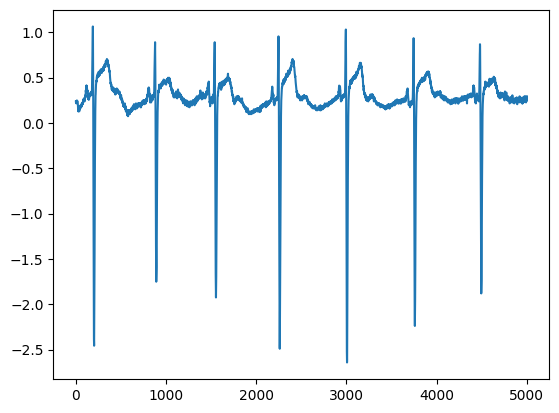

In [ ]:
tmp = X1_12[:,:,:]
print(tmp.shape)
plt.plot(tmp[0][6])

before (4, 12, 5000)
after (5000, 4, 12)


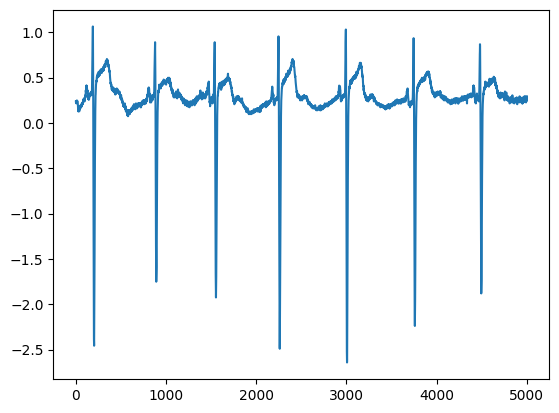

In [ ]:
# tmp = X1_12[:,:,:500]
print('before', tmp.shape)
tmp = np.transpose(tmp, axes=(2,0,1))
print('after', tmp.shape)
plt.plot(tmp[:,0,6])

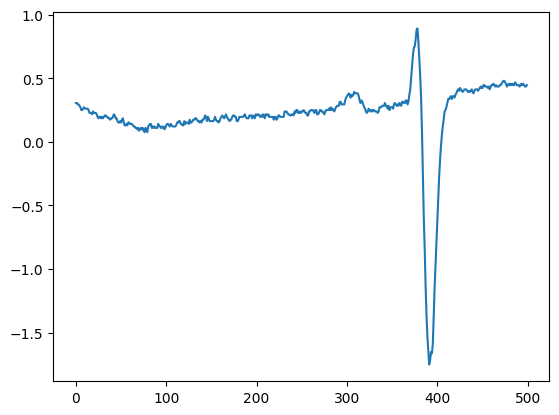

In [ ]:
plt.plot(tmp[500:1000,0,6])


In [ ]:
def plot_12_signals_of_three_sources(reading, corrupted, predicted):
    """
    plot a 12 electrodes reading of before/after. For example, before and after corruption,
    and actutal vs. predicted.
    """
    fig, axs = plt.subplots(6, 2)
    fig = plt.figure(figsize=(8, 6))

    leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']
    s=0
    for ax in axs.flat:
        ax.plot(reading[s])
        ax.plot(corrupted[s])
        ax.plot(predicted[s])
        ax.set_title(leads[s],fontsize=9)
        s+=1

    plt.tight_layout()
    plt.show()


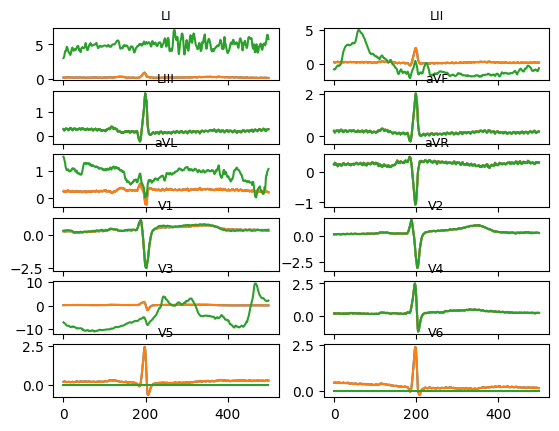

<Figure size 800x600 with 0 Axes>

In [ ]:
plot_12_signals_of_three_sources(src_[0],src_[0], data_corruptor.corrupt_a_batch(src_)[0])


In [ ]:
def plot_validation_signals_12leads(model, 
                                    validation_iterator, 
                                    device, 
                                    window)->None:
    """
    Plot actual vs. predicted. Results are a plot of `2 x <num_plots>`, first column
    contains plots of the source signals. Second column contains plots of the target
    signals, and their prediction.
    """


    # Choose a random batch to take. Search over the first 10 for time efficiency
    it = iter(validation_iterator)
    T=1
    t = trange(T)
    with torch.no_grad():
        for i in t:
            # get data from the first batch
            src, trg = next(it)    
            if i == 1:
                break

        # start training
        signal_length = src.shape[-1]
        start = np.random.randint(signal_length-window-1)

        src_ = src[:,:,start:(start+window)] # -> [batch_size, channels, window] = (4, 12, 500)
        trg_ = trg[:,:,start:(start+window)] # -> [batch_size, channels, window] = (4, 12, 500)
    
        # data corruption
        src_ = data_corruptor.corrupt_a_batch(src_)
        
        # fix shapes ( -> [length, batch_size, channels])
        src_ = np.transpose(src_, axes=(2,0,1))
        # trg_ = np.transpose(trg_, axes=(2,0,1))

        # move to gpu so we can pass through model
        src_ = src_.to(device)
        trg_ = trg_.to(device)

        # choose which signal from the first batch to look at
        batch_size = src.shape[1]
        sig_to_plot = np.random.randint(0,batch_size,1)

        # predict
        y_pred = model(src_,None).cpu().numpy()

        # prep signals for presentation
        original = trg_[:,sig_to_plot,:]
        corrupted = src_[:,sig_to_plot,:].cpu().numpy()
        reconstructed = y_pred[:,sig_to_plot,:]
        
        plot_12_signals_of_three_sources(original,corrupted, reconstructed)

        

In [ ]:
src_ = X1_12[:,:,:500]
src_.shape


(4, 12, 500)

# Find NaNs in the data

In [4]:
import os
os.chdir('../')

In [5]:
os.getcwd()

'/Users/davidharar/Documents/School/thesis/upstream_seq2seq'

In [6]:
from dataloader.DataLoader import DataGenerator_12leads

In [25]:
# --------------------------------
# Usage example
# --------------------------------
import pickle
DESTINATION_FOLDER = './data/processed/'
BATCH_SIZE = 512
with open(DESTINATION_FOLDER+"splits.pkl", 'rb') as handle:
    splits = pickle.load(handle)


train_generator = DataGenerator_12leads(
                                data_folder_path=DESTINATION_FOLDER, # path to relevant folder
                                batch_size=BATCH_SIZE,                        # batch size
                                list_IDs=splits['train'],            # list of relevat IDs (each ID is given in a <file>_<person> format)
                                shuffle = True                       # Whether to shuffle the list of IDs at the end of each epoch.
                                )

X1,X2 = train_generator.__getitem__(0)
print(X1.shape, X2.shape)

(512, 12, 5000) (512, 12, 5000)


In [26]:
import numpy as np
from tqdm import trange
it = iter(train_generator)
T = len(train_generator)
# set progress bar
t = trange(T, desc='Within epoch loss (training)', leave=True)

for i in t:
    # get data
    src, trg = next(it)
    # validate data
    if np.isnan(src.astype(float)).sum()>0:
        print(i)


Within epoch loss (training):  56%|█████▋    | 45/80 [12:07<09:26, 16.17s/it]


KeyboardInterrupt: 

In [23]:
src = np.array([1,2,3,None])
np.isnan(src.astype(float)).sum()

1

In [20]:
src = np.array([1,2,3])
src

array([1, 2, 3])